Run 1/3
Original SRA is optimizing "f1"
Run 2/3
Original SRA is optimizing "f1"
Run 3/3
Original SRA is optimizing "f1"


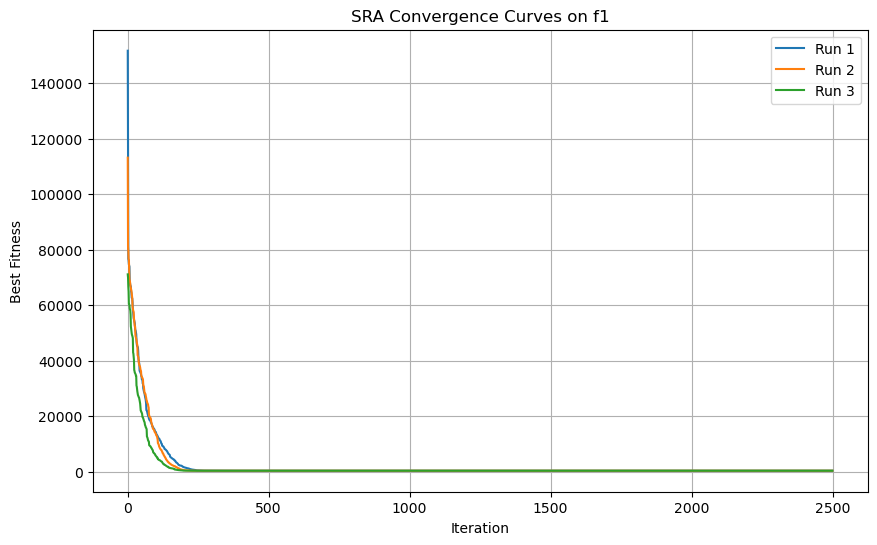

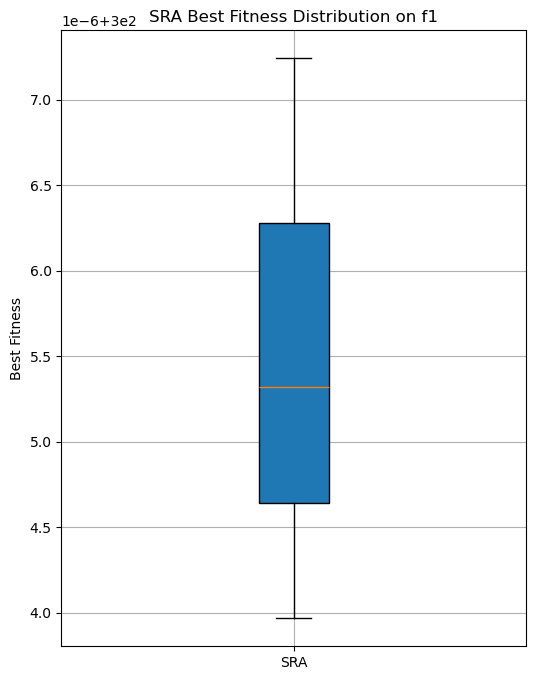

Best fitness values across 3 runs: [300.00000531990975, 300.0000039682989, 300.0000072429072]
Mean best fitness: 300.000005510372
Standard deviation of best fitness: 1.3436199188859172e-06


In [1]:
import random
import numpy
import math
import time
import opfunu
import pytest
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy
import matplotlib.pyplot as plt
# import opfunu.cec_based.F12022

class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

def SRA(objf, lb, ub, dim, PopSize, iters, function_name):
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    lb = numpy.array(lb)
    ub = numpy.array(ub) 
    L = 0.5
    h = 6.625e-34
    Cost = numpy.full(PopSize, float("inf"))
    pos = numpy.zeros((PopSize, dim))
    Psai = numpy.zeros((PopSize, dim))
    for i in range(dim):
        pos[:, i] = numpy.random.uniform(0, 1, PopSize) * (ub[i] - lb[i]) + lb[i]
    
    for i in range(PopSize):
        for j in range(dim):
            pos[i, j] = numpy.clip(pos[i, j], lb[j], ub[j])
            Psai[i, j] = math.sqrt(2/L) * numpy.sin(pos[i, j]) * numpy.exp(2)
        Cost[i] = objf.evaluate(pos[i, :])

    SmellOrder = numpy.sort(Cost)
    SmellIndex = numpy.argsort(Cost)
    Worst_Cost = SmellOrder[PopSize-1]
    Best_Cost = SmellOrder[0]
    sorted_population = pos[SmellIndex, :]
    Best_X = sorted_population[0, :]
    sorted_Psai = Psai[SmellIndex, :]
    Best_Psai = sorted_Psai[0, :]
    Worst_Psai = sorted_Psai[PopSize-1, :]

    convergence_curve = numpy.zeros(iters)
    s = solution()
    print(f'Original SRA is optimizing "{function_name}"')
    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(iters):
        b = 1 - (l ** (1.0 / 5)) / (iters ** (1.0 / 5)) 
        SmellOrder = numpy.sort(Cost)  
        SmellIndex = numpy.argsort(Cost)
        sorted_Psai = Psai[SmellIndex, :]
        Best_Psai = sorted_Psai[0, :]
        Worst_Psai = sorted_Psai[PopSize-1, :]

        Seq = numpy.array(range(PopSize))
        R = PopSize - Seq
        p = (R / PopSize) ** 2
           
        for i in range(PopSize):
            h2 = p[i]
            Xnew = numpy.zeros(dim)
            vc = numpy.random.uniform(-b, b, dim) 
            Z = Levy(dim)
            k = 1
            if random.random() < 0.03:
                Xnew = numpy.random.uniform(0, 1, size=dim) * (ub - lb) + lb
            else:
                ids_except_current = [_ for _ in range(PopSize) if _ != i]
                id_1, id_2 = random.sample(ids_except_current, 2) 
                Threshold = (l / iters) ** 3
                if numpy.abs(p[i]) < Threshold: 
                    if numpy.random.rand() < 0.5:
                        Xnew = k * random.random() + 2 * pos[i, :] - pos[i-1, :]
                    else:
                        Xnew = Best_X - 0.1 * Z + numpy.random.rand() * ((ub - lb) * numpy.random.rand() + lb)
                else:
                    pos_1 = Best_X + random.random() * vc * (h * (Best_Psai - Worst_Psai) + (h2 * (Psai[id_1, :] - 2 * Psai[i, :] + Psai[id_2, :]))) / Psai[i, :]
                    pos_2 = pos[i, :] + random.random() * vc * (h * (Best_Psai - Worst_Psai) + (h2 * (Psai[id_1, :] + 2 * Psai[i, :] + Psai[id_2, :]))) / Psai[i, :]
                    Xnew = where(uniform(0, 1) < 0.5, pos_1, pos_2)

            Xnew = numpy.clip(Xnew, lb, ub)
            Xnew_Cost = objf.evaluate(Xnew)
            if Cost[i] > Xnew_Cost:
                Cost[i] = Xnew_Cost 
                pos[i, :] = Xnew
                if Cost[i] < Best_Cost:
                    Best_X = pos[i, :]
                    Best_Cost = Cost[i]
            if Cost[i] > Worst_Cost:
                Worst_Cost = Cost[i]                    
            Psai[i, :] = numpy.sin(random.random() * pos[i, :])
        
        convergence_curve[l] = Best_Cost

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "Original SRA"
    s.objfname = function_name
    s.best = Best_Cost
    return s

def Levy(dim):
    beta = 1.5
    sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta) 
    u = 0.01 * numpy.random.randn(dim) * sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v), (1 / beta))
    step = numpy.divide(u, zz)
    return step

# Parameters
NumOfRuns = 3
dim = 20
PopSize = 30
iters = 2500
lb = -100
ub = 100
function_name = "f1"
if function_name ==  "f1":
    problem = opfunu.cec_based.F12022(ndim=dim)

elif function_name == "f2":
    problem = opfunu.cec_based.F22022(ndim=dim)

elif function_name == "f3":
    problem = opfunu.cec_based.F32022(ndim=dim)
    
elif function_name == "f4":
    problem = opfunu.cec_based.F42022(ndim=dim)

elif function_name == "f5":
    problem = opfunu.cec_based.F52022(ndim=dim)
        
elif function_name == "f6":
    problem = opfunu.cec_based.F62022(ndim=dim)

elif function_name == "f7":
    problem = opfunu.cec_based.F72022(ndim=dim)

elif function_name == "f8":
    problem = opfunu.cec_based.F82022(ndim=dim)
    
elif function_name == "f9":
    problem = opfunu.cec_based.F92022(ndim=dim)

elif function_name == "f10":
    problem = opfunu.cec_based.F102022(ndim=dim)   
       
else:
    print("the objective Function is Not belongs to CEC2022")

# Run SRA multiple times and collect results
best_fitness_values = []
convergence_curves = []

for run in range(NumOfRuns):
    print(f"Run {run + 1}/{NumOfRuns}")
    s = SRA(problem, lb, ub, dim, PopSize, iters, function_name)
    best_fitness_values.append(s.best)
    convergence_curves.append(s.convergence)

# Plot convergence curves
plt.figure(figsize=(10, 6))
for run in range(NumOfRuns):
    plt.plot(convergence_curves[run], label=f'Run {run + 1}')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.title(f'SRA Convergence Curves on {function_name}')
plt.legend()
plt.grid(True)
# plt.savefig('sra_convergence.png')
plt.show()
plt.close()

# Plot box plot
plt.figure(figsize=(6, 8))
plt.boxplot(best_fitness_values, vert=True, patch_artist=True)
plt.ylabel('Best Fitness')
plt.title(f'SRA Best Fitness Distribution on {function_name}')
plt.xticks([1], ['SRA'])
plt.grid(True)
plt.show()

print(f"Best fitness values across {NumOfRuns} runs: {best_fitness_values}")
print(f"Mean best fitness: {numpy.mean(best_fitness_values)}")
print(f"Standard deviation of best fitness: {numpy.std(best_fitness_values)}")